In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             3222 non-null   float64
 1   bath            3222 non-null   float64
 2   acre_lot        3222 non-null   float64
 3   zip_code        3222 non-null   float64
 4   house_size      3222 non-null   float64
 5   prev_sold_date  3222 non-null   object 
 6   price           3222 non-null   float64
dtypes: float64(6), object(1)
memory usage: 176.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             3222 non-null   float64
 1   bath            3222 non-null   float64
 2   acre_lot        3222 non-null   float64
 3   zip_code        3222 non-null   float64
 4   house_size      3222 non-null   float64
 5   price           3222 non-null   float64
 6   prev_sold_year  3222 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 176.3 KB


In [5]:
outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)

zip_code
8016.0    58
8081.0    55
8046.0    55
8210.0    51
8757.0    48
          ..
7081.0     1
8329.0     1
8327.0     1
8326.0     1
7853.0     1
Name: zip_code, Length: 421, dtype: int64

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([8016])]
#,8081,8046,8210

In [7]:
features = ["bed","bath","house_size","prev_sold_year","acre_lot"]
num_features_to_select = len(features)-1
random_state_value = 42

In [8]:
#"bed","bath","acre_lot","latitude","longitude","county","house_size","prev_sold_year"
X = one_zipcode_df[features]
y = one_zipcode_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [9]:
#"LinearRegression","RFE","SequentialFeatureSelector","SelectFromModel","PolynomialBestFeatures","PolynomialFeatures"
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[]}

In [10]:

def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [11]:
lgr = LinearRegression(fit_intercept=False)
lgr_model = lgr.fit(X_train,y_train)
lgr_predict = lgr_model.predict(X_test)
print_more_stuff("Linear Regression", y_test, lgr_predict)

Linear Regression EVS = 0.667405147
Linear Regression MSE = 4,275,861,804.635525
Linear Regression MAE = 45,903.330516
Linear Regression R2 = 0.653720


In [12]:
lgr_rfe = RFE(LinearRegression(), n_features_to_select=num_features_to_select)
lgr_rfe.fit(X, y)
lgr_rfe_selected_features = lgr_rfe.get_support()
print('The selected features are:', list(X.columns[lgr_rfe_selected_features]))

The selected features are: ['bed', 'bath', 'house_size', 'acre_lot']


In [13]:
X_rfe = one_zipcode_df[list(X.columns[lgr_rfe_selected_features])]
y_rfe = one_zipcode_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [14]:
lgr_rfe = LinearRegression(fit_intercept=False)
lgr_rfe_model = lgr_rfe.fit(X_rfe_train,y_rfe_train)
lgr_rfe_predict = lgr_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination", y_test, lgr_rfe_predict)

Recursive Feature Elimination EVS = 0.666847790
Recursive Feature Elimination MSE = 4,225,613,843.290601
Recursive Feature Elimination MAE = 45,570.564659
Recursive Feature Elimination R2 = 0.657789


In [15]:
lgr_sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=num_features_to_select)
lgr_sfs.fit(X, y)
lgr_sfs_selected_features = lgr_sfs.get_support()
print('The selected features are:', list(X.columns[lgr_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'house_size', 'acre_lot']


In [16]:
X_sfs = one_zipcode_df[list(X.columns[lgr_sfs_selected_features])]
y_sfs = one_zipcode_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [17]:
lgr_sfs = LinearRegression(fit_intercept=False)
lgr_sfs_model = lgr_sfs.fit(X_sfs_train,y_sfs_train)
lgr_sfs_predict = lgr_sfs_model.predict(X_sfs_test)
print_more_stuff("Sequential Feature Selector", y_test, lgr_sfs_predict)

Sequential Feature Selector EVS = 0.666847790
Sequential Feature Selector MSE = 4,225,613,843.290601
Sequential Feature Selector MAE = 45,570.564659
Sequential Feature Selector R2 = 0.657789


In [18]:
lgr_sfm = SelectFromModel(estimator=LinearRegression(), threshold=1000)
lgr_sfm.fit(X,y)
lgr_sfm_selected_features = lgr_sfm.get_support()
print('The selected features are:', list(X.columns[lgr_sfm_selected_features]))

The selected features are: ['bed', 'bath', 'acre_lot']


In [19]:
X_sfm = one_zipcode_df[list(X.columns[lgr_sfm_selected_features])]
y_sfm = one_zipcode_df["price"]
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = train_test_split(X_sfm, y_sfm, test_size=0.3, random_state=random_state_value)

In [20]:
lgr_sfm = LinearRegression(fit_intercept=False)
lgr_sfm.fit(X_sfm_train,y_sfm_train)
lgr_sfm_predict = lgr_sfm.predict(X_sfm_test)
print_more_stuff("Select From Model",y_sfm_test,lgr_sfm_predict)

Select From Model EVS = 0.668201681
Select From Model MSE = 4,452,834,980.533628
Select From Model MAE = 47,714.634959
Select From Model R2 = 0.639388


In [21]:
pipeline_gscv = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('ploy_model', LinearRegression())
])

pipeline_params={"poly_features__degree":[1,2,3,4,5],"poly_features__include_bias":[False],"ploy_model__fit_intercept":[True]}
grid_searchcv = GridSearchCV(pipeline_gscv, param_grid=pipeline_params, cv=5, verbose=1)

In [22]:
grid_searchcv.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly_features', PolynomialFeatures()),
                                       ('ploy_model', LinearRegression())]),
             param_grid={'ploy_model__fit_intercept': [True],
                         'poly_features__degree': [1, 2, 3, 4, 5],
                         'poly_features__include_bias': [False]},
             verbose=1)

In [23]:
print(f"Best parameters found: {grid_searchcv.best_params_}")

Best parameters found: {'ploy_model__fit_intercept': True, 'poly_features__degree': 1, 'poly_features__include_bias': False}


In [24]:
pipeline_params = {}
for what in grid_searchcv.best_params_:
    if pipeline_params.get(what) == None:
        pipeline_params[what] = []
    pipeline_params[what].append(grid_searchcv.best_params_[what])
pipeline_params

{'ploy_model__fit_intercept': [True],
 'poly_features__degree': [1],
 'poly_features__include_bias': [False]}

In [25]:
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()), 
    ('ploy_model', LinearRegression(fit_intercept=True))
])

poly_grid_searchcv = GridSearchCV(poly_pipeline, param_grid=pipeline_params, cv=5, verbose=1)

poly_grid_searchcv.fit(X_train,y_train)
poly_pipe_predict = poly_grid_searchcv.predict(X_test)
print_more_stuff("Polynomial Features",y_test,poly_pipe_predict)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Polynomial Features EVS = 0.647927699
Polynomial Features MSE = 4,501,074,059.769176
Polynomial Features MAE = 47,500.334726
Polynomial Features R2 = 0.635481


In [26]:
poly_predict_df = pd.DataFrame(poly_pipe_predict).reset_index()
poly_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_predict_df = pd.DataFrame(lgr_predict).reset_index()
lgr_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_sfm_predict_df = pd.DataFrame(lgr_sfm_predict).reset_index()
lgr_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_sfs_predict_df = pd.DataFrame(lgr_sfs_predict).reset_index()
lgr_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_rfe_predict_df = pd.DataFrame(lgr_rfe_predict).reset_index()
lgr_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

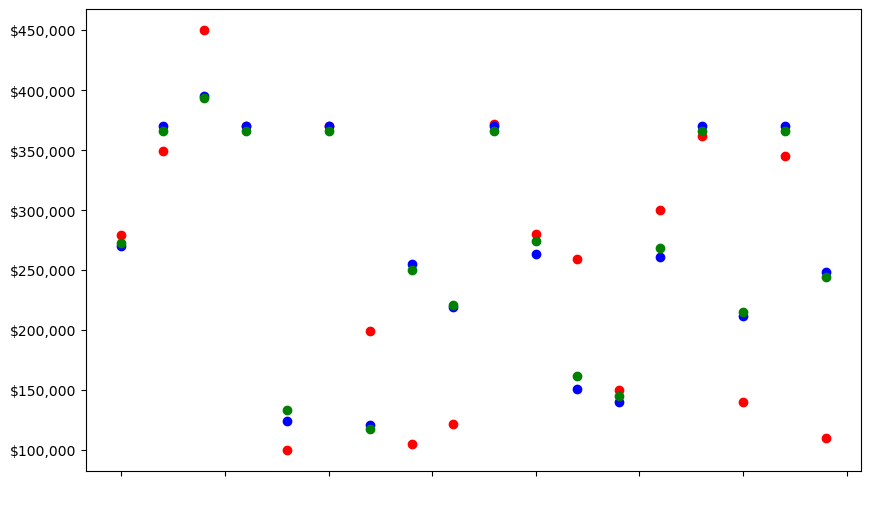

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(poly_predict_df.index,poly_predict_df["prediction"], color="blue")
plt.scatter(lgr_predict_df.index,lgr_predict_df["prediction"], color="green")
plt.show()

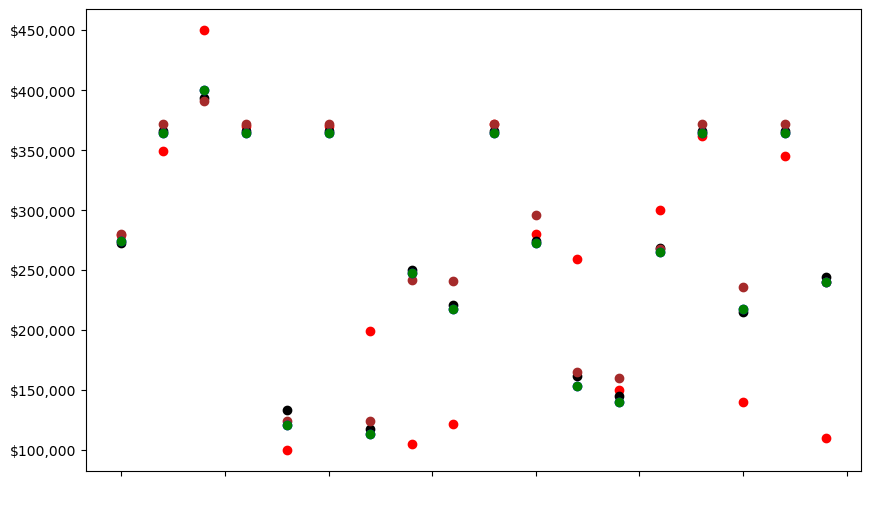

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lgr_predict_df.index,lgr_predict_df["prediction"], color="black")
plt.scatter(lgr_sfm_predict_df.index,lgr_sfm_predict_df["prediction"], color="brown")
plt.scatter(lgr_rfe_predict_df.index,lgr_rfe_predict_df["prediction"], color="blue")
plt.scatter(lgr_sfs_predict_df.index,lgr_sfs_predict_df["prediction"], color="green")
plt.show()

In [29]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score
model,,,,
Linear Regression,0.667405147,"45,903.330516","4,275,861,804.635525",0.653720
Recursive Feature Elimination,0.666847790,"45,570.564659","4,225,613,843.290601",0.657789
Sequential Feature Selector,0.666847790,"45,570.564659","4,225,613,843.290601",0.657789
Select From Model,0.668201681,"47,714.634959","4,452,834,980.533628",0.639388
Polynomial Features,0.647927699,"47,500.334726","4,501,074,059.769176",0.635481
